In [1]:
import sys
!{sys.executable} -m pip install backtesting yfinance 

You should consider upgrading via the '/Users/andrewilliams/Documents/Dev/DS-2.9-Technical-Seminar/my_env/bin/python3 -m pip install --upgrade pip' command.


In [8]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

# models 
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier

from yahoofinancials import YahooFinancials as yf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
%matplotlib inline

In [9]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install alpha_vantage

You should consider upgrading via the '/Users/andrewilliams/Documents/Dev/DS-2.9-Technical-Seminar/my_env/bin/python3 -m pip install --upgrade pip' command.


## Alphavantage Intraday Data up to 2 years 

In [10]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
from functools import reduce

def alpha_vantage_data(symbol, interval):
    apiKey = 'IOLIXAXKGPI3A4QM'

    ts = TimeSeries(key = apiKey, output_format = 'csv')

    data_frames = []

    #download the csv
    month_one = ts.get_intraday_extended(symbol = symbol , interval = interval , slice ='year1month1')
    one = pd.DataFrame(list(month_one[0]))
    data_frames.append(one)

    month_two = ts.get_intraday_extended(symbol = symbol, interval = interval, slice ='year1month2')
    month_two = pd.DataFrame(list(month_two[0]))
    data_frames.append(month_two)
    
    month_three = ts.get_intraday_extended(symbol = symbol, interval = interval, slice ='year1month3')
    month_three = pd.DataFrame(list(month_three[0]))
    data_frames.append(month_three)
    
    month_four = ts.get_intraday_extended(symbol = symbol, interval = interval, slice ='year1month4')
    month_four = pd.DataFrame(list(month_four[0]))
    data_frames.append(month_four)
    
    month_five = ts.get_intraday_extended(symbol = symbol, interval = interval, slice ='year1month5')
    month_five = pd.DataFrame(list(month_five[0]))
    data_frames.append(month_five)
    
#     month_six = ts.get_intraday_extended(symbol = symbol, interval = interval, slice ='year1month6')
#     month_six = pd.DataFrame(list(month_six[0]))
#     data_frames.append(month_six)
    
#     month_seven = ts.get_intraday_extended(symbol = symbol, interval = interval, slice ='year1month7')
#     month_seven = pd.DataFrame(list(month_seven[0]))
#     data_frames.append(month_seven)
    
    
#     month_eight = ts.get_intraday_extended(symbol = symbol, interval = interval, slice ='year1month8')
#     month_eight = pd.DataFrame(list(month_eight[0]))
#     data_frames.append(month_eight)

#     month_nine = ts.get_intraday_extended(symbol = symbol, interval = interval, slice ='year1month9')
#     month_nine = pd.DataFrame(list(month_nine[0]))
#     data_frames.append(month_nine)
    
#     month_ten = ts.get_intraday_extended(symbol = symbol, interval = interval, slice ='year1month10')
#     month_ten = pd.DataFrame(list(month_ten[0]))
#     data_frames.append(month_ten)
    
#     month_eleven = ts.get_intraday_extended(symbol = symbol, interval = interval, slice ='year1month11')
#     month_eleven = pd.DataFrame(list(month_eleven[0]))
#     data_frames.append(month_eleven) 
    
#     month_twelve = ts.get_intraday_extended(symbol = symbol, interval = interval, slice ='year1month12')
#     month_twelve = pd.DataFrame(list(month_twelve[0]))
#     data_frames.append(month_twelve)
    
    df = pd.concat(data_frames)
    
#     #df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['DATE'], how='outer'), data_frames).fillna('void')

    #csv --> dataframe
#     df = pd.DataFrame(list(df_merged[0]))

    # print(df)

    #setup of column and index
    header_row=0
    df.columns = df.iloc[header_row]
    df = df.drop(header_row)
    df['time'] = pd.to_datetime(df['time'])
    df.set_index('time', inplace=True)
    df = df.drop_duplicates()

    #show output
    return df 

In [11]:
df = alpha_vantage_data('PLTR', '15min')

df.tail()
## combine dataframes 

,open,high,low,close,volume
time,,,,,
2020-12-14 05:15:00,27.81,27.93,27.81,27.92,3402
2020-12-14 05:00:00,27.84,27.96,27.8,27.81,10669
2020-12-14 04:45:00,27.77,27.85,27.75,27.83,8862
2020-12-14 04:30:00,27.73,27.84,27.71,27.76,12888
2020-12-14 04:15:00,27.48,27.8,27.31,27.71,15174


In [12]:
df = df.apply(pd.to_numeric)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6569 entries, 2021-05-12 20:00:00 to 2020-12-14 04:15:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    6569 non-null   float64
 1   high    6569 non-null   float64
 2   low     6569 non-null   float64
 3   close   6569 non-null   float64
 4   volume  6569 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 307.9 KB


In [13]:
len(df)

6569

## Yahoo Finance Data 

In [14]:
# Picking the stock to predict and get historical data
import yfinance as yf
import datetime

def get_stock_data(tickers, start_date='', end_date='', freq='daily'):
    '''This function takes the list of stock ticker and get historical OHLC data
    
    Parameters
    ----------
    tickers : list/iterable
        Iterable object containing ticker symbols as strings
    start_date : str, optional
        Takes start date of data, format = 'yyyy-mm-dd'
    end_date : str, optional
        Takes end date of data, format = 'yyyy-mm-dd'
        
    Returns
    -------
    pandas DataFrame containing pricing data and list containing tickers whose data was not found
    
    '''

#     ticker_not_found=[]
#     for ticker in tickers:
#         yf_engine = yf(ticker)
#         price = yf_engine.get_historical_price_data(start_date,end_date,freq)
#         #store the data in DataFrame
#         try:
#             ticker_data = pd.DataFrame(price[ticker]['prices'])
#             ticker_data = ticker_data.drop('date', axis=1) # We will use formatted_date columns instead
#         except:
#             ticker_not_found.append(ticker)
#             continue
            
#     return ticker_data, ticker_not_found



    # import mplfinance as mpf
    # from datetime import datetime
    
    start_date = datetime.datetime.now() - datetime.timedelta(59)
    current_date = datetime.datetime.today()
    # sd = datetime(2021, 2, 5)
    # ed = datetime(2021, 4, 2)
    for ticker in tickers:
        data = yf.download(tickers=ticker, start=start_date, end=current_date, interval="15m")
    # mpf.plot(df,type='candle',mav=(3,6,9),volume=True)
    return data

In [ ]:
import datetime
start_date = datetime.datetime.now() - datetime.timedelta(59)
current_date = datetime.datetime.today()
#We will use Google stock ticker to predict its prices
ticker = ['CF']
# start_date = '2020-09-01'
# end_date = '2021-4-02'

# df, ticker_not_found = get_stock_data(ticker, start_date, end_date)

df = get_stock_data(ticker)
df.head()

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/Users/andrewilliams/opt/anaconda3/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/Users/andrewilliams/opt/anaconda3/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/andrewilliams/Documents/Dev/DS-2.9-Technical-Seminar/my_env/lib/python3.8/site-packages/multitasking/__init__.py", line 102, in _run_via_pool
    return callee(*args, **kwargs)
  File "/Users/andrewilliams/Documents/Dev/DS-2.9-Technical-Seminar/my_env/lib/python3.8/site-packages/yfinance/multi.py", line 167, in _download_one_threaded
    data = _download_one(ticker, start, end, auto_adjust, back_adjust,
  File "/Users/andrewilliams/Documents/Dev/DS-2.9-Technical-Seminar/my_env/lib/python3.8/site-packages/yfinance/multi.py", line 179, in _download_one
    return Ticker(ticker).history(period=period, interval=interval,
  File "/Users/andrewilliams/Documents/Dev/

In [ ]:
df.tail()

In [ ]:
len(df)

## Grab Alpaca Intraday Data

In [ ]:
# Install a pip package in the current Jupyter kernel
# import sys
# !{sys.executable} -m pip install alpaca-trade-api

In [ ]:
import alpaca_trade_api as tradeapi
import requests
from datetime import datetime

In [ ]:
# ## Grab alpaca intraday data 
# # import alpaca_trade_api as tradeapi

# endpoint = "https://data.alpaca.markets/v1"
# headers = {
#     "APCA-API-KEY-ID": "PKHOA1VIMFOC6P6YFNS8",
#     "APCA-API-SECRET-KEY": "BIZJBuginzyMC3JpPdBvRqTWVkb1Xol6FjSuaFZN"
# }

# #json.loads(open("account.json",'r').read())
# api = tradeapi.REST(headers["APCA-API-KEY-ID"], headers["APCA-API-SECRET-KEY"], base_url='https://paper-api.alpaca.markets')

# def hist_data(symbol, dataframe, timeframe="15Min", limit=1000, start="", end="", after="", until=""):
#     '''Returns the historical bar data for a group of stocks '''
#     df_data = {}
#     # Get Requests for Bar Data
#     bar_url = endpoint + "/bars/{}".format(timeframe)


#     params = {
#         "symbols": symbol,
#         "start": start,
#         "end": end,
#         "limit": limit,
#         "timeframe": timeframe
#     }

#     r = requests.get(bar_url, headers=headers, params=params)

#     json_dump = r.json()
#     # loop through stock data
#     for symbol in json_dump:
#         # convert json into pandas dataframe
#         temp = pd.DataFrame(json_dump[symbol])
#         temp.rename({"t":"datadate", "o": "open", 'h':'high', 'l':'low', "c":"close", 'v':'volume'}, axis=1, inplace=True)

#         temp['tic'] = symbol

#         dataframe = pd.concat([dataframe, temp])

#     return dataframe


In [ ]:
# #limit = 2 
# def getData(tickers, start="", end="", limit=20):
#     dataframes = dict()
#     for symbol in tickers:
#         dataframes[symbol] = pd.DataFrame()#columns = [symbol])

#     # time is in seconds

#     # starttime = time.time()
#     # # will go for 8 hours
#     # # timeout = starttime + 60 * 5 # 8 hrs 60 * 8
#     # timeout = starttime + 1

#     # while time.time() <= timeout:
#     # print("****************************************************")
#     for company in tickers:
#         # print("printing data for {} at {}".format(company, time.time()))
#         dataframes[company] = hist_data(company, dataframes[company], '15Min', start=start, end=end)

#     final_prices = dataframes[tickers[0]]
# #     print(final_prices)
    
#     for key, value in dataframes.items():
# #         print('value',value)
#         final_prices = pd.concat([final_prices, value])


#     final_prices = final_prices.sort_values(by=['datadate'])

# #     print('final prices: \n',final_prices)

# #     for index, row in final_prices.iterrows():
# #         year = str(datetime.fromtimestamp(int(row['datadate'])).year)
# #         month = str(datetime.fromtimestamp(int(row['datadate'])).month)
# #         #minute = str(datetime.fromtimestamp(int(row['datadate'])).minute)
        
# #         if len(month) == 1:
# #             month = "0" + month
# #         day = str(datetime.fromtimestamp(int(row['datadate'])).day)
# #         if len(day) == 1:
# #             day = "0" + day
# #         # print(year+month+day)
# #         # row['datadate'] = year+month+day
# #         final_prices.at[index, 'datadate'] = year+month+day#+minute

# #     final_prices = final_prices.reset_index()
# #     final_prices = final_prices.drop(["index"], axis=1)
# #     final_prices = final_prices.drop_duplicates()
    
#     print('final prices: \n',final_prices)
    
#     return final_prices

In [ ]:
# df = getData(['PLTR','AAPL'])

# df.head()

# df['adjclose'] = df['close']

df.head(1)

In [ ]:
# df['date'] = pd.to_datetime(df['formatted_date'])
# df = df.set_index(pd.DatetimeIndex(df['date'])) 
# df.drop(df.columns[-1], axis=1, inplace=True)
# df.head()




df.columns = ['open', 'high', 'low', 'close', 'volume', 'adjclose']

## Data Cleaning 

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
df[df.isna()==True].sum().sum()

In [ ]:
df['volume'].plot(label='Volume', color='r');
plt.legend();

In [ ]:

df['adjclose'].plot(label='Closing Price', color='g');
plt.legend();

## Feature Engineering 

We will now create certain features from the pricing data which would include:
1. SMA_20 : Simple Moving Average of 20 day window
2. Std_dev : Standard Deviation for 20 day window
3. Band_1 : Bollinger band created using SMA_20 + Std_dev
4. Band_2 : Bollinger band created using SMA_20 - Std_dev
5. ON_returns : whether there was up or down move from prior day closing price to current day opening price
6. dist_from_mean : How much distant stock prices are from the mean
7. vix_data: CBOE Volatility index price from the prior day

In [ ]:
def BBANDS(data, n_lookback, n_std):
    """Bollinger bands indicator"""
    hlc3 = (data.high + data.low + data.close) / 3
    mean, std = hlc3.rolling(n_lookback).mean(), hlc3.rolling(n_lookback).std()
    upper = mean + n_std*std
    lower = mean - n_std*std
    return upper, lower

In [ ]:
from backtesting.test import EURUSD, SMA

def get_clean_data (df, start_date=None, end_date=None):
    '''This function takes the historical OHLC data and return features as we defined above
    
    Parameters
    ----------
    df : DataFrame
        Dataframe containing pricing data
    start_date : str, optional
        Takes start date of data for vix, format = 'yyyy-mm-dd'
    end_date : str, optional
        Takes ebd date of data for vix, format = 'yyyy-mm-dd'
        
    Returns
    -------
    pandas DataFrame containing scaled features except categorical features
    '''
    
    features = df.copy()
    # Some datetime features for good measure
    features['X_day'] = features.index.dayofweek
    features['X_hour'] = features.index.hour
#     features = features.drop(['formatted_date'], axis=1)
    #creating features as stated above
    features['volume'] = features['volume'].shift(1)
    close = features.close.values
    sma10 = SMA(features.close, 10)
    sma20 = SMA(features.close, 20)
    sma50 = SMA(features.close, 50)
    sma100 = SMA(features.close, 100)
    upper, lower = BBANDS(features, 20, 2)
#     upper, lower = BBANDS(features, 20, 2)

    # Design matrix / independent features:

    # Price-derived features
    features['X_SMA10'] = (close - sma10) / close
    features['X_SMA20'] = (close - sma20) / close
    features['X_SMA50'] = (close - sma50) / close
    features['X_SMA100'] = (close - sma100) / close

    features['X_DELTA_SMA10'] = (sma10 - sma20) / close
    features['X_DELTA_SMA20'] = (sma20 - sma50) / close
    features['X_DELTA_SMA50'] = (sma50 - sma100) / close

    # Indicator features
    features['X_MOM'] = features.close.pct_change(periods=2)
    features['X_BB_upper'] = (upper - close) / close
    features['X_BB_lower'] = (lower - close) / close
    features['X_BB_width'] = (upper - lower) / close
    
    
    features['SMA'] = features['adjclose'].rolling(window=20).mean().shift(1)
    features['Std_20'] = features['adjclose'].rolling(window=20).std().shift(1)
    features['Band_1'] = features['SMA'] - features['Std_20']
    features['Band_2'] = features['SMA'] + features['Std_20']
    features['ON_returns'] = features['close'] - features['open'].shift(-1)
    features['ON_returns'] = features['ON_returns'].shift(1)
    features['ON_returns_signal'] = np.where(features['ON_returns']<0, 'up', 'down')
    features['dist_from_mean'] = features['adjclose'].shift(1) - features['X_SMA10']
    
#     print('features\n', features.head())
    
#     #Obtaining Vix Data and combining with existing features of stock
#     ticker = ['^VIX']
#     start_date = start_date
#     end_date = end_date
#     vix_data, ticker_not_found = get_stock_data(ticker, start_date, end_date)
#     vix_data = pd.DataFrame(vix_data['adjclose'].shift(1))
#     vix_data = vix_data.rename(columns = {'adjclose':'vix_data'})
#     comb_features = pd.concat([features,vix_data], axis=1)
#     comb_features = comb_features.dropna() #dropping NaN values
    comb_features = pd.get_dummies(features, columns=['ON_returns_signal']) #for categorical variables
    comb_features = comb_features.drop('ON_returns', axis=1) #dropping original categorical column
    comb_features = comb_features.drop('close', axis=1) #not really needed this value since we have adj close now
    ###Create return column to predict
    comb_features['stock_move'] = np.where(comb_features['adjclose']-
                                           comb_features['adjclose'].shift(-1)<0, "Buy", "Sell")
    features_clean = comb_features.dropna() #Dropping Nan values
    features_clean = features_clean[:-1] #Drop last row which do not have any stock signal
    features_clean.tail()
    return features_clean

In [ ]:
features = get_clean_data(df)

In [ ]:
features.tail()

In [ ]:
features.drop(['ON_returns_signal_down','ON_returns_signal_up'], axis=1, inplace=True)


## Feature Correlation Matrix

In [ ]:

corr_table = features.drop(['high', 'low'], axis=1).corr()
fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(corr_table, annot = True, ax=ax)
plt.show()

In [ ]:
features.shape

## Transforming the Data: Train-test-split 

In [ ]:
import numpy as np

def get_X(data):
    """Return model design matrix X"""
    return data.filter(like='X').values


def get_y(data):
    """Return dependent variable y"""
    y = data.adjclose.pct_change(48).shift(-48)  # Returns after roughly two days
    y[y.between(-.004, .004)] = 0             # Devalue returns smaller than 0.4%
    y[y > 0] = 1
    y[y < 0] = -1
    return y


def get_clean_Xy(df):
    """Return (X, y) cleaned of NaN values"""
    X = get_X(df)
    y = get_y(df).values
    isnan = np.isnan(y)
    X = X[~isnan]
    y = y[~isnan]
    return X, y

In [108]:
len(features.columns)

24

In [110]:
np.random.seed(40)

X, y = get_clean_Xy(features)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=0)


In [97]:
X.shape

(944, 13)

In [98]:
X_train.shape

(472, 13)

In [100]:
# ## Load in model 
# import pickle
# with open('Optimized-Extra-Classifier-89', 'rb') as file:
#     oec = pickle.load(file)
    

# # print("Test score: {0:.2f} %".format(100 * score))
# y_predict = oec.predict(X)

# y_predict

## Prediction Classifier 

In [112]:
from sklearn.preprocessing import LabelEncoder 
labelencoder= LabelEncoder() #initializing an object of class LabelEncoder
features['stock_move'] = labelencoder.fit_transform(features['stock_move']) 

In [113]:
X = features.drop(['stock_move'], axis=1)
y = features['stock_move']

In [117]:
y

Datetime
2021-03-11 14:45:00-05:00    1
2021-03-11 15:00:00-05:00    0
2021-03-11 15:15:00-05:00    1
2021-03-11 15:30:00-05:00    0
2021-03-11 15:45:00-05:00    1
                            ..
2021-05-05 14:30:00-04:00    0
2021-05-05 14:45:00-04:00    0
2021-05-05 15:00:00-04:00    0
2021-05-05 15:15:00-04:00    0
2021-05-05 15:30:00-04:00    0
Name: stock_move, Length: 992, dtype: int64

In [116]:
features.head()

,open,high,low,volume,adjclose,X_day,X_hour,X_SMA10,X_SMA20,X_SMA50,...,X_MOM,X_BB_upper,X_BB_lower,X_BB_width,SMA,Std_20,Band_1,Band_2,dist_from_mean,stock_move
Datetime,,,,,,,,,,,,,,,,,,,,,
2021-03-11 14:45:00-05:00,50.500000,50.575100,50.444500,50.500000,73539,3,14,0.002160,0.000897,0.019615,...,0.002383,0.004796,-0.005929,0.010725,79505.40,55595.685179,23909.714821,135101.085179,60597.997840,1
2021-03-11 15:00:00-05:00,50.470001,50.509899,50.299999,50.470001,67765,3,15,0.000030,-0.000618,0.016970,...,-0.002475,0.005782,-0.003765,0.009547,71155.15,40674.806465,30480.343535,111829.956465,73538.999970,0
2021-03-11 15:15:00-05:00,50.375000,50.520000,50.270000,50.375000,138634,3,15,0.000803,0.000364,0.017122,...,-0.000793,0.004695,-0.004818,0.009513,63832.30,22832.622834,40999.677166,86664.922834,67764.999197,1
2021-03-11 15:30:00-05:00,50.410000,50.494999,50.340000,50.430000,77822,3,15,-0.000427,-0.000429,0.015500,...,0.000099,0.005595,-0.003882,0.009477,65542.25,26943.880410,38598.369590,92486.130410,138634.000427,0
2021-03-11 15:45:00-05:00,50.375000,50.590000,50.299999,50.380001,251564,3,15,0.002256,0.002666,0.017569,...,0.002082,0.002324,-0.006894,0.009218,64592.70,26105.434694,38487.265306,90698.134694,77821.997744,1


Since predictions are somewhat evenly distributed so there is lesser chance of bias in our predictor model. Having "Buy" signals more than sell signal kind of makes sense since Jan, stock price has risen.


## Split Data 

In [143]:
#test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

## Transforming Data 

In [144]:

# #Scale the features
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [145]:
# X_train

## Training the models

In [146]:
# Put models in a dictionary
models = {"KNN": KNeighborsClassifier(),
          "Logistic Regression": LogisticRegression(), 
          "Random Forest": RandomForestClassifier(),
          "SGD Classifier": SGDClassifier(), 
         "SVM": svm.SVC(kernel = 'rbf')}

# Create function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models : a dict of different Scikit-Learn machine learning models
    X_train : training data
    X_test : testing data
    y_train : labels assosciated with training data
    y_test : labels assosciated with test data
    """
    # Random seed for reproducible results
    np.random.seed(42)
    # Make a list to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(X_test, y_test)
    
    print('classification Accuracy')
    return model_scores

## Model Comparison 

In [147]:
model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)
model_scores

classification Accuracy


{'KNN': 0.6330645161290323,
 'Logistic Regression': 0.6149193548387096,
 'Random Forest': 0.6008064516129032,
 'SGD Classifier': 0.5564516129032258,
 'SVM': 0.625}

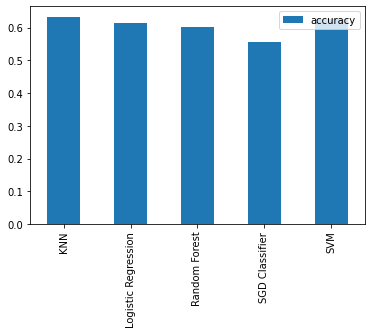

In [148]:
model_compare = pd.DataFrame(model_scores, index=['accuracy'])
model_compare.T.plot.bar();

## Hyperparameter Tuning 

In [124]:
# Different LogisticRegression hyperparameters
log_reg_grid = {"C": np.logspace(-4, 4, 20),
                "solver": ["liblinear"], 
               "max_iter": np.arange(10, 200, 10)}

# Different RandomForestClassifier hyperparameters
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

# Different KNN hyperparameters
knn_grid = { "n_neighbors": np.arange(1, 29, 1), 
           "leaf_size": np.arange(30, 200, 10),
           "weights": ["uniform", "distance"],
           "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute']}



In [125]:
# Setup random seed
np.random.seed(42)

# Setup random hyperparameter search for LogisticRegression
rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                                param_distributions=log_reg_grid,
                                cv=5,
                                n_iter=20,
                                verbose=True)

# Fit random hyperparameter search model
rs_log_reg.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/andrewilliams/Documents/Dev/DS-2.9-Technical-Seminar/my_env/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/andrewilliams/Documents/Dev/DS-2.9-Technical-Seminar/my_env/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/andrewilliams/Documents/Dev/DS-2.9-Technical-Seminar/my_env/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/andrewilliams/Documents/Dev/DS-2.9-Technical-Seminar/my_env/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  

In [126]:
# Setup random seed
np.random.seed(42)

# Setup random hyperparameter search for RandomForestClassifier
rfc = RandomizedSearchCV(RandomForestClassifier(),
                           param_distributions=rf_grid,
                           cv=5,
                           n_iter=50,
                           verbose=True)

# accuracy ={}
# for i in range(1,300):
#     classifier = RandomForestClassifier(n_estimators=i, random_state=15)
#     classifier.fit(X_train, y_train)
#     y_pred_ev = classifier.predict(X_test)
#     accuracy[i] = accuracy_score(y_test, y_pred_ev)

# Fit random hyperparameter search model
rfc.fit(X_train, y_train);

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [127]:
# Setup random seed
np.random.seed(42)

# Setup random hyperparameter search for KNN
rs_knn = RandomizedSearchCV(KNeighborsClassifier(),
                                param_distributions=knn_grid,
                                cv=5,
                                n_iter=100,
                                verbose=True)

# Fit random hyperparameter search model
rs_knn.fit(X_train, y_train);

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [128]:
# Find the best parameters
rs_log_reg.best_params_

{'solver': 'liblinear', 'max_iter': 70, 'C': 11.288378916846883}

In [129]:
# Find the best parameters
rfc.best_params_

{'n_estimators': 860,
 'min_samples_split': 16,
 'min_samples_leaf': 5,
 'max_depth': 5}

In [130]:
rs_knn.best_params_

{'weights': 'uniform',
 'n_neighbors': 17,
 'leaf_size': 140,
 'algorithm': 'brute'}

## Score New Models 

In [149]:
# randomized search random forest model
rfc.score(X_test, y_test)

0.7157258064516129

In [150]:
rs_log_reg.score(X_test, y_test)

0.6209677419354839

In [151]:
rs_knn.score(X_test, y_test)

0.6713709677419355

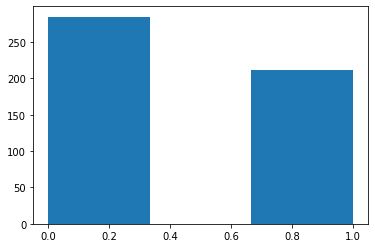

In [152]:
y_pred = rfc.predict(X_test)
plt.hist(y_pred, bins=3);

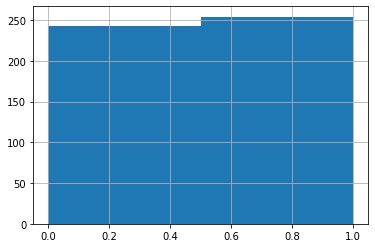

In [153]:
y_test.hist(bins=2);

Accuracy score of the model is:  0.7157258064516129


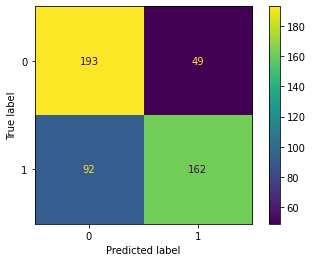

In [154]:
print ("Accuracy score of the model is: ", accuracy_score(y_test, y_pred))
plot_confusion_matrix(rfc, X_test, y_test);


In [155]:
# plt.figure(figsize=(11 , 6))
# plt.plot(list(accuracy.keys()), list(accuracy.values()))
# plt.title('Accuracy based on different tree sizes in the forest')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy Score')
# plt.show();


In [156]:
## Save rfc 
## Serialize Optimized Random Forest 
import pickle 
pickle.dump(rfc, open('rf-72', 'wb'))




# Super Learner Algorithm 

In [407]:
import sys
!{sys.executable} -m pip install lightgbm #xgboost #optuna

In [408]:
from mlens.ensemble import SuperLearner
import optuna
from optuna.samplers import TPESampler

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import RidgeClassifier, Perceptron, PassiveAggressiveClassifier, LogisticRegression, SGDClassifier

## Single Model Training

In [409]:
class Optimizer:
    def __init__(self, metric, trials=30):
        self.metric = metric
        self.trials = trials
        self.sampler = TPESampler(seed=666)
        
    def objective(self, trial):
        model = create_model(trial)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        if self.metric == 'acc':
            return accuracy_score(y_test, preds)
        else:
            return f1_score(y_test, preds)
            
    def optimize(self):
        study = optuna.create_study(direction="maximize", sampler=self.sampler)
        study.optimize(self.objective, n_trials=self.trials)
        return study.best_params

In [410]:
rf = RandomForestClassifier(
    random_state=666
)
rf.fit(X_train, y_train)
preds = rf.predict(X_test)

print('Random Forest accuracy: ', accuracy_score(y_test, preds))
# print('Random Forest f1-score: ', f1_score(y_test, preds))

def create_model(trial):
    max_depth = trial.suggest_int("max_depth", 2, 6)
    n_estimators = trial.suggest_int("n_estimators", 2, 150)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    model = RandomForestClassifier(
        min_samples_leaf=min_samples_leaf, 
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        random_state=666
    )
    return model

# optimizer = Optimizer('f1')
# rf_f1_params = optimizer.optimize()
# rf_f1_params['random_state'] = 666
# rf_f1 = RandomForestClassifier(
#     **rf_f1_params
# )
# rf_f1.fit(X_train, y_train)
# preds = rf_f1.predict(X_test)

# print('Optimized on F1 score')
# print('Optimized Random Forest: ', accuracy_score(y_test, preds))
# print('Optimized Random Forest f1-score: ', f1_score(y_test, preds))

optimizer = Optimizer('acc')
rf_acc_params = optimizer.optimize()
rf_acc_params['random_state'] = 666
rf_acc = RandomForestClassifier(
    **rf_acc_params
)
rf_acc.fit(X_train, y_train);
preds = rf_acc.predict(X_test)

print('Optimized on accuracy')
print('Optimized Random Forest: ', accuracy_score(y_test, preds))
# print('Optimized Random Forest f1-score: ', f1_score(y_test, preds))

[I 2021-04-22 13:15:52,377] A new study created in memory with name: no-name-25a14c74-b429-4842-860e-7e8e70626e32


Random Forest accuracy:  0.7760910815939279


[I 2021-04-22 13:15:52,804] Trial 0 finished with value: 0.6030993042378242 and parameters: {'max_depth': 5, 'n_estimators': 127, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.6030993042378242.
[I 2021-04-22 13:15:53,277] Trial 1 finished with value: 0.6030993042378242 and parameters: {'max_depth': 5, 'n_estimators': 143, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.6030993042378242.
[I 2021-04-22 13:15:53,312] Trial 2 finished with value: 0.5721062618595826 and parameters: {'max_depth': 4, 'n_estimators': 9, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.6030993042378242.
[I 2021-04-22 13:15:53,420] Trial 3 finished with value: 0.5692599620493358 and parameters: {'max_depth': 4, 'n_estimators': 31, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.6030993042378242.
[I 2021-04-22 13:15:53,658] Trial 4 finished with value: 0.5493358633776091 and parameters: {'max_depth': 2, 'n_estimators': 106, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.60309930423

Optimized on accuracy
Optimized Random Forest:  0.6223908918406073


In [42]:
## Serialize Optimized Random Forest 
# import pickle 
# pickle.dump(rf_acc, open('optimized-rfc', 'wb'))



In [411]:
X_val = X_test
y_val = y_test
X = X_train 
y = y_train 

In [412]:
xgb = XGBClassifier(
    random_state=666
)
xgb.fit(X, y)
preds = xgb.predict(X_val)

print('XGBoost accuracy: ', accuracy_score(y_val, preds))


def create_model(trial):
    max_depth = trial.suggest_int("max_depth", 2, 6)
    n_estimators = trial.suggest_int("n_estimators", 1, 150)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0000001, 1)
    gamma = trial.suggest_uniform('gamma', 0.0000001, 1)
    subsample = trial.suggest_uniform('subsample', 0.0001, 1.0)
    model = XGBClassifier(
        learning_rate=learning_rate, 
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        gamma=gamma, 
        subsample=subsample,
        random_state=666
    )
    return model


optimizer = Optimizer('acc')
xgb_acc_params = optimizer.optimize()
xgb_acc_params['random_state'] = 666
xgb_acc = XGBClassifier(
    **xgb_acc_params
)
xgb_acc.fit(X, y)
preds = xgb_acc.predict(X_val)

print('Optimized on accuracy')
print('Optimized XGBoost accuracy: ', accuracy_score(y_val, preds))

/Users/andrewilliams/Documents/Dev/DS-2.9-Technical-Seminar/my_env/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:16:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-22 13:16:10,314] A new study created in memory with name: no-name-de0ce192-e01a-4d22-b4d3-98c9eb4b7402


XGBoost accuracy:  0.7615433270082227
[13:16:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/andrewilliams/Documents/Dev/DS-2.9-Technical-Seminar/my_env/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2021-04-22 13:16:11,160] Trial 0 finished with value: 0.7375079063883618 and parameters: {'max_depth': 5, 'n_estimators': 127, 'learning_rate': 0.6765143682861918, 'gamma': 0.7278580844622691, 'subsample': 0.9514628116505947}. Best is trial 0 with value: 0.7375079063883618.
/Users/andrewilliams/Documents/Dev/DS-2.9-Technical-Seminar/my_env/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a fu

[13:16:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:16:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-22 13:16:11,665] Trial 2 finished with value: 0.640101201771031 and parameters: {'max_depth': 3, 'n_estimators': 112, 'learning_rate': 0.19289208375138345, 'gamma': 0.700844782081506, 'subsample': 0.29329878305864704}. Best is trial 0 with value: 0.7375079063883618.
/Users/andrewilliams/Documents/Dev/DS-2.9-Technical-Seminar/my_env/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2021-04-22 13:16:11,680] Trial 3 finished with value: 0.5616698292220114 and parameters: {'max_depth': 5, 'n_estimators': 1, 'learning_rate': 0.1128577423459426, 'gamma': 0.11095376089207946, 'subsample': 0.247743

[13:16:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:16:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-22 13:16:12,024] Trial 4 finished with value: 0.6318785578747628 and parameters: {'max_depth': 2, 'n_estimators': 110, 'learning_rate': 0.34003500795113273, 'gamma': 0.19750323664268268, 'subsample': 0.9091886748803036}. Best is trial 0 with value: 0.7375079063883618.
/Users/andrewilliams/Documents/Dev/DS-2.9-Technical-Seminar/my_env/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:16:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-22 13:16:12,674] Trial 5 finished with value: 0.706831119544592 and parameters: {'max_depth': 6, 'n_estimators': 80, 'learning_rate': 0.2591319234557709, 'gamma': 0.5838126604440433, 'subsample': 0.3257580838683153}. Best is trial 0 with value: 0.7375079063883618.
/Users/andrewilliams/Documents/Dev/DS-2.9-Technical-Seminar/my_env/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:16:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-22 13:16:13,329] Trial 6 finished with value: 0.6998734977862112 and parameters: {'max_depth': 6, 'n_estimators': 94, 'learning_rate': 0.8188737086904494, 'gamma': 0.5473454656384197, 'subsample': 0.41677033473305986}. Best is trial 0 with value: 0.7375079063883618.
/Users/andrewilliams/Documents/Dev/DS-2.9-Technical-Seminar/my_env/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:16:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-22 13:16:13,678] Trial 7 finished with value: 0.6502213788741303 and parameters: {'max_depth': 5, 'n_estimators': 56, 'learning_rate': 0.0751666364305374, 'gamma': 0.7751930009328656, 'subsample': 0.2194873035183015}. Best is trial 0 with value: 0.7375079063883618.
/Users/andrewilliams/Documents/Dev/DS-2.9-Technical-Seminar/my_env/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2021-04-22 13:16:13,861] Trial 8 finished with value: 0.5942441492726123 and parameters: {'max_depth': 2, 'n_estimators': 74, 'learning_rate': 0.15367398663261667, 'gamma': 0.8284651504059493, 'subsample': 0.191449

[13:16:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:16:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-22 13:16:14,158] Trial 9 finished with value: 0.6448450347881088 and parameters: {'max_depth': 3, 'n_estimators': 85, 'learning_rate': 0.9023803996540212, 'gamma': 0.851788356584257, 'subsample': 0.4181401523901378}. Best is trial 0 with value: 0.7375079063883618.
/Users/andrewilliams/Documents/Dev/DS-2.9-Technical-Seminar/my_env/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:16:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-22 13:16:15,016] Trial 10 finished with value: 0.7286527514231499 and parameters: {'max_depth': 4, 'n_estimators': 150, 'learning_rate': 0.6502310988771591, 'gamma': 0.3436433301007432, 'subsample': 0.9776081334747528}. Best is trial 0 with value: 0.7375079063883618.
/Users/andrewilliams/Documents/Dev/DS-2.9-Technical-Seminar/my_env/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:16:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-22 13:16:15,752] Trial 11 finished with value: 0.7311827956989247 and parameters: {'max_depth': 4, 'n_estimators': 147, 'learning_rate': 0.6377276431264177, 'gamma': 0.3179553747132384, 'subsample': 0.9839509574531247}. Best is trial 0 with value: 0.7375079063883618.
/Users/andrewilliams/Documents/Dev/DS-2.9-Technical-Seminar/my_env/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:16:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-22 13:16:16,495] Trial 12 finished with value: 0.7239089184060721 and parameters: {'max_depth': 4, 'n_estimators': 149, 'learning_rate': 0.5571306163724984, 'gamma': 0.37314707678320724, 'subsample': 0.7876624135529685}. Best is trial 0 with value: 0.7375079063883618.
/Users/andrewilliams/Documents/Dev/DS-2.9-Technical-Seminar/my_env/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:16:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-22 13:16:17,298] Trial 13 finished with value: 0.7235926628716003 and parameters: {'max_depth': 5, 'n_estimators': 130, 'learning_rate': 0.7091039397790568, 'gamma': 0.9683903574368246, 'subsample': 0.7082435065629176}. Best is trial 0 with value: 0.7375079063883618.
/Users/andrewilliams/Documents/Dev/DS-2.9-Technical-Seminar/my_env/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:16:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-22 13:16:17,717] Trial 14 finished with value: 0.5230866540164453 and parameters: {'max_depth': 5, 'n_estimators': 133, 'learning_rate': 0.4320740818033063, 'gamma': 0.3898418247216437, 'subsample': 0.029616583038213795}. Best is trial 0 with value: 0.7375079063883618.
/Users/andrewilliams/Documents/Dev/DS-2.9-Technical-Seminar/my_env/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2021-04-22 13:16:17,928] Trial 15 finished with value: 0.6944971537001897 and parameters: {'max_depth': 4, 'n_estimators': 38, 'learning_rate': 0.7804340475761541, 'gamma': 0.23984808643419203, 'subsample': 0.8

[13:16:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/andrewilliams/Documents/Dev/DS-2.9-Technical-Seminar/my_env/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:16:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-22 13:16:18,415] Trial 16 finished with value: 0.6742567994939912 and parameters: {'max_depth': 3, 'n_estimators': 132, 'learning_rate': 0.9629569132597372, 'gamma': 0.9893273690645659, 'subsample': 0.6169933589245892}. Best is trial 0 with value: 0.7375079063883618.
/Users/andrewilliams/Documents/Dev/DS-2.9-Technical-Seminar/my_env/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:16:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-22 13:16:19,270] Trial 17 finished with value: 0.7536369386464263 and parameters: {'max_depth': 6, 'n_estimators': 110, 'learning_rate': 0.5909389632868929, 'gamma': 0.655235400813831, 'subsample': 0.9893744751073859}. Best is trial 17 with value: 0.7536369386464263.
/Users/andrewilliams/Documents/Dev/DS-2.9-Technical-Seminar/my_env/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:16:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-22 13:16:20,311] Trial 18 finished with value: 0.7615433270082227 and parameters: {'max_depth': 6, 'n_estimators': 107, 'learning_rate': 0.4687122257988131, 'gamma': 0.6394257049197503, 'subsample': 0.8843161484878157}. Best is trial 18 with value: 0.7615433270082227.
/Users/andrewilliams/Documents/Dev/DS-2.9-Technical-Seminar/my_env/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:16:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-22 13:16:21,284] Trial 19 finished with value: 0.7697659709044908 and parameters: {'max_depth': 6, 'n_estimators': 99, 'learning_rate': 0.47726388424495025, 'gamma': 0.6556592219046772, 'subsample': 0.8504145600313903}. Best is trial 19 with value: 0.7697659709044908.
/Users/andrewilliams/Documents/Dev/DS-2.9-Technical-Seminar/my_env/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:16:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-22 13:16:21,574] Trial 20 finished with value: 0.7289690069576218 and parameters: {'max_depth': 6, 'n_estimators': 29, 'learning_rate': 0.47256798790445786, 'gamma': 0.4748155000815166, 'subsample': 0.640781126405347}. Best is trial 19 with value: 0.7697659709044908.
/Users/andrewilliams/Documents/Dev/DS-2.9-Technical-Seminar/my_env/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:16:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-22 13:16:22,542] Trial 21 finished with value: 0.7545857052498419 and parameters: {'max_depth': 6, 'n_estimators': 102, 'learning_rate': 0.37218781011967905, 'gamma': 0.6138307806038967, 'subsample': 0.8534497666135381}. Best is trial 19 with value: 0.7697659709044908.
/Users/andrewilliams/Documents/Dev/DS-2.9-Technical-Seminar/my_env/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:16:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-22 13:16:23,331] Trial 22 finished with value: 0.7590132827324478 and parameters: {'max_depth': 6, 'n_estimators': 97, 'learning_rate': 0.3729352827180554, 'gamma': 0.6222031716948176, 'subsample': 0.8611349690614417}. Best is trial 19 with value: 0.7697659709044908.
/Users/andrewilliams/Documents/Dev/DS-2.9-Technical-Seminar/my_env/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:16:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-22 13:16:24,073] Trial 23 finished with value: 0.7507906388361796 and parameters: {'max_depth': 6, 'n_estimators': 95, 'learning_rate': 0.5199784493356745, 'gamma': 0.48023646065730063, 'subsample': 0.7379889379360859}. Best is trial 19 with value: 0.7697659709044908.
/Users/andrewilliams/Documents/Dev/DS-2.9-Technical-Seminar/my_env/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:16:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-22 13:16:25,013] Trial 24 finished with value: 0.7583807716635041 and parameters: {'max_depth': 6, 'n_estimators': 115, 'learning_rate': 0.3121489696373104, 'gamma': 0.8993414340012825, 'subsample': 0.8773166988951857}. Best is trial 19 with value: 0.7697659709044908.
/Users/andrewilliams/Documents/Dev/DS-2.9-Technical-Seminar/my_env/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:16:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-22 13:16:25,640] Trial 25 finished with value: 0.7400379506641366 and parameters: {'max_depth': 5, 'n_estimators': 90, 'learning_rate': 0.44432659851638934, 'gamma': 0.5378715520758524, 'subsample': 0.6237161563599487}. Best is trial 19 with value: 0.7697659709044908.
/Users/andrewilliams/Documents/Dev/DS-2.9-Technical-Seminar/my_env/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:16:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-22 13:16:26,122] Trial 26 finished with value: 0.7454142947501581 and parameters: {'max_depth': 6, 'n_estimators': 63, 'learning_rate': 0.25355668063250864, 'gamma': 0.6648078430282481, 'subsample': 0.7605588480135438}. Best is trial 19 with value: 0.7697659709044908.
/Users/andrewilliams/Documents/Dev/DS-2.9-Technical-Seminar/my_env/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:16:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-22 13:16:26,824] Trial 27 finished with value: 0.7463630613535737 and parameters: {'max_depth': 5, 'n_estimators': 120, 'learning_rate': 0.40097052357536467, 'gamma': 0.7764157702599557, 'subsample': 0.8992143977897817}. Best is trial 19 with value: 0.7697659709044908.
/Users/andrewilliams/Documents/Dev/DS-2.9-Technical-Seminar/my_env/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:16:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-22 13:16:27,643] Trial 28 finished with value: 0.7482605945604048 and parameters: {'max_depth': 6, 'n_estimators': 99, 'learning_rate': 0.5138330416194699, 'gamma': 0.43763439163326456, 'subsample': 0.6918134380951609}. Best is trial 19 with value: 0.7697659709044908.
/Users/andrewilliams/Documents/Dev/DS-2.9-Technical-Seminar/my_env/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:16:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-04-22 13:16:28,197] Trial 29 finished with value: 0.7160025300442757 and parameters: {'max_depth': 5, 'n_estimators': 74, 'learning_rate': 0.22406483930842497, 'gamma': 0.7520274017581641, 'subsample': 0.5482257865467624}. Best is trial 19 with value: 0.7697659709044908.
/Users/andrewilliams/Documents/Dev/DS-2.9-Technical-Seminar/my_env/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:16:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Optimized on accuracy
Optimized XGBoost accuracy:  0.7697659709044908


In [221]:
## Serialize Optimized Random Forest 
import pickle 
pickle.dump(xgb_acc, open('optimized-XGboost-85', 'wb'))



In [414]:
lgb = LGBMClassifier(
    random_state=666
)
lgb.fit(X, y)
preds = lgb.predict(X_val)

print('LightGBM accuracy: ', accuracy_score(y_val, preds))

def create_model(trial):
    max_depth = trial.suggest_int("max_depth", 2, 6)
    n_estimators = trial.suggest_int("n_estimators", 1, 150)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0000001, 1)
    num_leaves = trial.suggest_int("num_leaves", 2, 3000)
    min_child_samples = trial.suggest_int('min_child_samples', 3, 200)
    model = LGBMClassifier(
        learning_rate=learning_rate, 
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        num_leaves=num_leaves, 
        min_child_samples=min_child_samples,
        random_state=666
    )
    return model



optimizer = Optimizer('acc')
lgb_acc_params = optimizer.optimize()
lgb_acc_params['random_state'] = 666
lgb_acc = LGBMClassifier(
    **lgb_acc_params
)
lgb_acc.fit(X, y)
preds = lgb_acc.predict(X_val)

print('Optimized on accuracy')
print('Optimized LightGBM accuracy: ', accuracy_score(y_val, preds))

[I 2021-04-22 13:16:44,906] A new study created in memory with name: no-name-dd6e1be2-30b8-4d02-95a2-22cdd9e27e23
[I 2021-04-22 13:16:45,095] Trial 0 finished with value: 0.7160025300442757 and parameters: {'max_depth': 5, 'n_estimators': 127, 'learning_rate': 0.6765143682861918, 'num_leaves': 2184, 'min_child_samples': 191}. Best is trial 0 with value: 0.7160025300442757.


LightGBM accuracy:  0.7754585705249842


[I 2021-04-22 13:16:45,214] Trial 1 finished with value: 0.5806451612903226 and parameters: {'max_depth': 2, 'n_estimators': 63, 'learning_rate': 0.048812888918720654, 'num_leaves': 301, 'min_child_samples': 103}. Best is trial 0 with value: 0.7160025300442757.
[I 2021-04-22 13:16:45,421] Trial 2 finished with value: 0.6593927893738141 and parameters: {'max_depth': 3, 'n_estimators': 112, 'learning_rate': 0.19289208375138345, 'num_leaves': 2103, 'min_child_samples': 61}. Best is trial 0 with value: 0.7160025300442757.
[I 2021-04-22 13:16:45,432] Trial 3 finished with value: 0.5262492093611638 and parameters: {'max_depth': 5, 'n_estimators': 1, 'learning_rate': 0.1128577423459426, 'num_leaves': 334, 'min_child_samples': 52}. Best is trial 0 with value: 0.7160025300442757.
[I 2021-04-22 13:16:45,623] Trial 4 finished with value: 0.6265022137887413 and parameters: {'max_depth': 2, 'n_estimators': 110, 'learning_rate': 0.34003500795113273, 'num_leaves': 594, 'min_child_samples': 183}. Best

Optimized on accuracy
Optimized LightGBM accuracy:  0.7675521821631879


In [415]:
## Serialize Optimized Random Forest 
import pickle 
pickle.dump(lgb_acc, open('optimized-LighGBM-86', 'wb'))

In [416]:
lr = LogisticRegression(
    random_state=666
)
lr.fit(X, y)
preds = lr.predict(X_val)

print('Logistic Regression: ', accuracy_score(y_val, preds))
# print('Logistic Regression f1-score: ', f1_score(y_val, preds))

Logistic Regression:  0.5376344086021505


/Users/andrewilliams/Documents/Dev/DS-2.9-Technical-Seminar/my_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [417]:
dt = DecisionTreeClassifier(
    random_state=666
)
dt.fit(X, y)
preds = dt.predict(X_val)

print('Decision Tree accuracy: ', accuracy_score(y_val, preds))

def create_model(trial):
    max_depth = trial.suggest_int("max_depth", 2, 6)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 16)
    min_weight_fraction_leaf = trial.suggest_uniform('min_weight_fraction_leaf', 0.0, 0.5)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    model = DecisionTreeClassifier(
        min_samples_split=min_samples_split, 
        min_weight_fraction_leaf=min_weight_fraction_leaf, 
        max_depth=max_depth, 
        min_samples_leaf=min_samples_leaf, 
        random_state=666
    )
    return model


optimizer = Optimizer('acc')
dt_acc_params = optimizer.optimize()
dt_acc_params['random_state'] = 666
dt_acc = DecisionTreeClassifier(
    **dt_acc_params
)
dt_acc.fit(X, y)
preds = dt_acc.predict(X_val)

print('Optimized on accuracy')
print('Optimized Decision Tree accuracy: ', accuracy_score(y_val, preds))

[I 2021-04-22 13:17:01,721] A new study created in memory with name: no-name-5d163780-b145-496d-9653-d1d63d65fee2
[I 2021-04-22 13:17:01,727] Trial 0 finished with value: 0.5234029095509172 and parameters: {'max_depth': 5, 'min_samples_split': 14, 'min_weight_fraction_leaf': 0.3382571679688127, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.5234029095509172.
[I 2021-04-22 13:17:01,735] Trial 1 finished with value: 0.5234029095509172 and parameters: {'max_depth': 6, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.20679384939326173, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.5234029095509172.
[I 2021-04-22 13:17:01,743] Trial 2 finished with value: 0.5455407969639469 and parameters: {'max_depth': 2, 'min_samples_split': 9, 'min_weight_fraction_leaf': 0.10012376966723874, 'min_samples_leaf': 8}. Best is trial 2 with value: 0.5455407969639469.
[I 2021-04-22 13:17:01,752] Trial 3 finished with value: 0.5234029095509172 and parameters: {'max_depth': 2, 'min_samples_sp

Decision Tree accuracy:  0.7017710309930424


[I 2021-04-22 13:17:01,934] Trial 15 finished with value: 0.5455407969639469 and parameters: {'max_depth': 3, 'min_samples_split': 11, 'min_weight_fraction_leaf': 0.0031660272970367304, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.5455407969639469.
[I 2021-04-22 13:17:01,954] Trial 16 finished with value: 0.5455407969639469 and parameters: {'max_depth': 2, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.11411675031894318, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.5455407969639469.
[I 2021-04-22 13:17:01,976] Trial 17 finished with value: 0.5278304870335231 and parameters: {'max_depth': 3, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.14236407805723023, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.5455407969639469.
[I 2021-04-22 13:17:02,000] Trial 18 finished with value: 0.5455407969639469 and parameters: {'max_depth': 3, 'min_samples_split': 11, 'min_weight_fraction_leaf': 0.004800673280669373, 'min_samples_leaf': 6}. Best is trial 2 with va

Optimized on accuracy
Optimized Decision Tree accuracy:  0.5509171410499684


In [418]:
bc = BaggingClassifier(
    random_state=666
)
bc.fit(X, y)
preds = bc.predict(X_val)

print('Bagging Classifier accuracy: ', accuracy_score(y_val, preds))

def create_model(trial):
    n_estimators = trial.suggest_int('n_estimators', 2, 200)
    max_samples = trial.suggest_int('max_samples', 0, 200)
    model = BaggingClassifier(
        n_estimators=n_estimators, 
        max_samples=max_samples, 
        random_state=666
    )
    return model


print('Optimized on F1-score')
print('Optimized Bagging Classifier accuracy: ', accuracy_score(y_val, preds))

optimizer = Optimizer('acc')
bc_acc_params = optimizer.optimize()
bc_acc_params['random_state'] = 666
bc_acc = BaggingClassifier(
    **bc_acc_params
)
bc_acc.fit(X, y)
preds = bc_acc.predict(X_val)

print('Optimized on accuracy')
print('Optimized Bagging Classifier accuracy: ', accuracy_score(y_val, preds))

[I 2021-04-22 13:17:09,247] A new study created in memory with name: no-name-c795a788-6fd3-47a4-a912-2fb262dd46ff


Bagging Classifier accuracy:  0.732764073371284
Optimized on F1-score
Optimized Bagging Classifier accuracy:  0.732764073371284


[I 2021-04-22 13:17:09,597] Trial 0 finished with value: 0.6116382036685643 and parameters: {'n_estimators': 141, 'max_samples': 169}. Best is trial 0 with value: 0.6116382036685643.
[I 2021-04-22 13:17:09,938] Trial 1 finished with value: 0.6087919038583175 and parameters: {'n_estimators': 136, 'max_samples': 146}. Best is trial 0 with value: 0.6116382036685643.
[I 2021-04-22 13:17:10,247] Trial 2 finished with value: 0.5069576217583808 and parameters: {'n_estimators': 191, 'max_samples': 2}. Best is trial 0 with value: 0.6116382036685643.
[I 2021-04-22 13:17:10,390] Trial 3 finished with value: 0.5328905755850727 and parameters: {'n_estimators': 84, 'max_samples': 9}. Best is trial 0 with value: 0.6116382036685643.
[I 2021-04-22 13:17:10,437] Trial 4 finished with value: 0.5426944971537002 and parameters: {'n_estimators': 21, 'max_samples': 102}. Best is trial 0 with value: 0.6116382036685643.
[I 2021-04-22 13:17:10,543] Trial 5 finished with value: 0.5907653383934219 and parameters:

Optimized on accuracy
Optimized Bagging Classifier accuracy:  0.6296647691334598


In [419]:
x_train

NameError: name 'x_train' is not defined

In [52]:
knn = KNeighborsClassifier()
knn.fit(X, y)
preds = knn.predict(X_val)

print('KNN accuracy: ', accuracy_score(y_val, preds))


sampler = TPESampler(seed=0)
def create_model(trial):
    n_neighbors = trial.suggest_int("n_neighbors", 2, 25)
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    return model


print('Optimized KNN accuracy: ', accuracy_score(y_val, preds))


optimizer = Optimizer('acc')
knn_acc_params = optimizer.optimize()
knn_acc = KNeighborsClassifier(
    **knn_acc_params
)
knn_acc.fit(X, y)
preds = knn_acc.predict(X_val)

print('Optimized on accuracy')
print('Optimized KNN accuracy: ', accuracy_score(y_val, preds))

[I 2021-01-25 21:47:08,056] A new study created in memory with name: no-name-e1efe0b4-0041-4d4c-9bc1-5a517083c958
[I 2021-01-25 21:47:08,059] Trial 0 finished with value: 0.3888888888888889 and parameters: {'n_neighbors': 14}. Best is trial 0 with value: 0.3888888888888889.
[I 2021-01-25 21:47:08,062] Trial 1 finished with value: 0.5555555555555556 and parameters: {'n_neighbors': 4}. Best is trial 1 with value: 0.5555555555555556.
[I 2021-01-25 21:47:08,065] Trial 2 finished with value: 0.3888888888888889 and parameters: {'n_neighbors': 15}. Best is trial 1 with value: 0.5555555555555556.
[I 2021-01-25 21:47:08,068] Trial 3 finished with value: 0.6111111111111112 and parameters: {'n_neighbors': 8}. Best is trial 3 with value: 0.6111111111111112.
[I 2021-01-25 21:47:08,071] Trial 4 finished with value: 0.4444444444444444 and parameters: {'n_neighbors': 11}. Best is trial 3 with value: 0.6111111111111112.
[I 2021-01-25 21:47:08,074] Trial 5 finished with value: 0.5 and parameters: {'n_ne

KNN accuracy:  0.5
Optimized KNN accuracy:  0.5
Optimized on accuracy
Optimized KNN accuracy:  0.6111111111111112


In [224]:
#Optimized KNN f1-score:  0.6306306306306305
abc = AdaBoostClassifier(
    random_state=66
)
abc.fit(X, y)
preds = abc.predict(X_val)

print('AdaBoost accuracy: ', accuracy_score(y_val, preds))

def create_model(trial):
    n_estimators = trial.suggest_int("n_estimators", 2, 150)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0005, 1.0)
    model = AdaBoostClassifier(
        n_estimators=n_estimators, 
        learning_rate=learning_rate, 
        random_state=666
    )
    return model


print('Optimized AdaBoost accuracy: ', accuracy_score(y_val, preds))

optimizer = Optimizer('acc')
abc_acc_params = optimizer.optimize()
abc_acc_params['random_state'] = 666
abc_acc = AdaBoostClassifier(
    **abc_acc_params
)
abc_acc.fit(X, y)
preds = abc_acc.predict(X_val)

print('Optimized on accuracy')
print('Optimized AdaBoost accuracy: ', accuracy_score(y_val, preds))

[I 2021-04-21 20:37:21,918] A new study created in memory with name: no-name-1b7ad30d-a1ac-4c5e-b69b-bc1dd7dcace2
[I 2021-04-21 20:37:22,091] Trial 0 finished with value: 0.625 and parameters: {'n_estimators': 106, 'learning_rate': 0.8442645495290093}. Best is trial 0 with value: 0.625.


AdaBoost accuracy:  0.6016949152542372
Optimized AdaBoost accuracy:  0.6016949152542372


[I 2021-04-21 20:37:22,259] Trial 1 finished with value: 0.6292372881355932 and parameters: {'n_estimators': 102, 'learning_rate': 0.7279941282194508}. Best is trial 1 with value: 0.6292372881355932.
[I 2021-04-21 20:37:22,477] Trial 2 finished with value: 0.6398305084745762 and parameters: {'n_estimators': 143, 'learning_rate': 0.01319684543625025}. Best is trial 2 with value: 0.6398305084745762.
[I 2021-04-21 20:37:22,578] Trial 3 finished with value: 0.635593220338983 and parameters: {'n_estimators': 63, 'learning_rate': 0.049288387403100035}. Best is trial 2 with value: 0.6398305084745762.
[I 2021-04-21 20:37:22,609] Trial 4 finished with value: 0.625 and parameters: {'n_estimators': 16, 'learning_rate': 0.5083122726141229}. Best is trial 2 with value: 0.6398305084745762.
[I 2021-04-21 20:37:22,666] Trial 5 finished with value: 0.6101694915254238 and parameters: {'n_estimators': 31, 'learning_rate': 0.74428209172969}. Best is trial 2 with value: 0.6398305084745762.
[I 2021-04-21 20

Optimized on accuracy
Optimized AdaBoost accuracy:  0.6419491525423728


In [53]:
## Serialize Optimized Random Forest 
import pickle 
pickle.dump(rf_acc, open('optimized-Adaboost', 'wb'))



In [253]:
etcs = ExtraTreesClassifier(
    random_state=666
)
etcs.fit(X, y)
preds = etcs.predict(X_val)

print('ExtraTreesClassifier accuracy: ', accuracy_score(y_val, preds))

def create_model(trial):
    n_estimators = trial.suggest_int("n_estimators", 2, 150)
    max_depth = trial.suggest_int("max_depth", 2, 6)
    model = ExtraTreesClassifier(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        random_state=10
    )
    return model


# print('Optimized ExtraTreesClassifier accuracy: ', accuracy_score(y_val, preds))

optimizer = Optimizer('acc')
et_acc_params = optimizer.optimize()
et_acc_params['random_state'] = 0
et_acc = ExtraTreesClassifier(
    **et_acc_params
)
et_acc.fit(X, y)
preds = et_acc.predict(X_val)

print('Optimized on accuracy')
print('Optimized ExtraTreesClassifier accuracy: ', accuracy_score(y_val, preds))

[I 2021-04-21 20:55:09,604] A new study created in memory with name: no-name-5ab0c284-e38c-4cdb-bc80-5495a846fb9a
[I 2021-04-21 20:55:09,706] Trial 0 finished with value: 0.7203389830508474 and parameters: {'n_estimators': 106, 'max_depth': 6}. Best is trial 0 with value: 0.7203389830508474.
[I 2021-04-21 20:55:09,800] Trial 1 finished with value: 0.6779661016949152 and parameters: {'n_estimators': 102, 'max_depth': 5}. Best is trial 0 with value: 0.7203389830508474.


ExtraTreesClassifier accuracy:  0.8898305084745762


[I 2021-04-21 20:55:09,925] Trial 2 finished with value: 0.6016949152542372 and parameters: {'n_estimators': 143, 'max_depth': 2}. Best is trial 0 with value: 0.7203389830508474.
[I 2021-04-21 20:55:09,983] Trial 3 finished with value: 0.6122881355932204 and parameters: {'n_estimators': 63, 'max_depth': 2}. Best is trial 0 with value: 0.7203389830508474.
[I 2021-04-21 20:55:10,001] Trial 4 finished with value: 0.6588983050847458 and parameters: {'n_estimators': 16, 'max_depth': 4}. Best is trial 0 with value: 0.7203389830508474.
[I 2021-04-21 20:55:10,032] Trial 5 finished with value: 0.673728813559322 and parameters: {'n_estimators': 31, 'max_depth': 5}. Best is trial 0 with value: 0.7203389830508474.
[I 2021-04-21 20:55:10,063] Trial 6 finished with value: 0.673728813559322 and parameters: {'n_estimators': 30, 'max_depth': 5}. Best is trial 0 with value: 0.7203389830508474.
[I 2021-04-21 20:55:10,107] Trial 7 finished with value: 0.6800847457627118 and parameters: {'n_estimators': 45

Optimized on accuracy
Optimized ExtraTreesClassifier accuracy:  0.722457627118644


In [254]:
preds = etcs.predict(X_val)
print('Optimized ExtraTreesClassifier accuracy: ', accuracy_score(y_val, preds))


Optimized ExtraTreesClassifier accuracy:  0.8898305084745762


In [256]:
## Serialize Optimized Extra Tree Classifier 
import pickle 
pickle.dump(et_acc, open('Optimized-Extra-Classifier-89', 'wb'))

In [392]:
## Load in model 
import pickle
with open('Optimized-Extra-Classifier-89', 'rb') as file:
    oec = pickle.load(file)
    
    


In [396]:
score = oec.score(X_test, y_test)
print("Test score: {0:.2f} %".format(100 * score))
y_predict = oec.predict(X_test)


Test score: 40.51 %


## Algorithmic Performance 

In [238]:
# Put models in a dictionary
models = {
        "Extra Trees Classifier:":et_acc, 
         "AdaBoost Classifier:": abc_acc, 
#          "KNN": knn_acc, 
#          "Logistic Regression": lr,
#          "Decision Tree Classifier": dt_acc,
         "Lgb classifier": lgb_acc, 
         "XGB Classifier": xgb_acc, 
         "Random Forest Classifier": rf_acc}
models

{'Extra Trees Classifier:': ExtraTreesClassifier(max_depth=6, n_estimators=62, random_state=0),
 'AdaBoost Classifier:': AdaBoostClassifier(learning_rate=0.012194177354099445, n_estimators=117,
                    random_state=666),
 'Lgb classifier': LGBMClassifier(learning_rate=0.2747865242166644, max_depth=5,
                min_child_samples=14, n_estimators=57, num_leaves=994,
                random_state=666),
 'XGB Classifier': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1,
               gamma=0.058153052911613476, gpu_id=-1, importance_type='gain',
               interaction_constraints='', learning_rate=0.8324303901142126,
               max_delta_step=0, max_depth=4, min_child_weight=1, missing=nan,
               monotone_constraints='()', n_estimators=23, n_jobs=16,
               num_parallel_tree=1, objective='multi:softprob', random_state=666,
               reg_alpha=0, reg_lambda=1, scale_pos

In [239]:
# Create function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models : a dict of different Scikit-Learn machine learning models
    X_train : training data
    X_test : testing data
    y_train : labels assosciated with training data
    y_test : labels assosciated with test data
    """
    # Random seed for reproducible results
    np.random.seed(42)
    # Make a list to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [240]:
model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)
model_scores

[20:44:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/andrewilliams/Documents/Dev/DS-2.9-Technical-Seminar/my_env/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


{'Extra Trees Classifier:': 0.722457627118644,
 'AdaBoost Classifier:': 0.6419491525423728,
 'Lgb classifier': 0.8686440677966102,
 'XGB Classifier': 0.8538135593220338,
 'Random Forest Classifier': 0.7542372881355932}

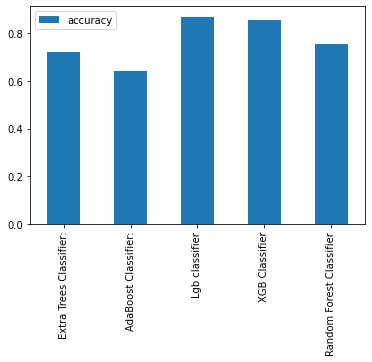

In [241]:
model_compare = pd.DataFrame(model_scores, index=['accuracy'])
model_compare.T.plot.bar();

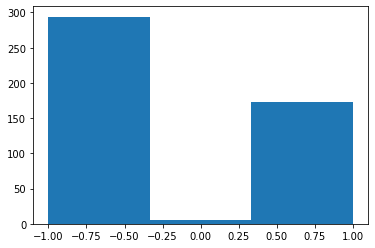

In [257]:

y_pred = rfc.predict(X_test)
plt.hist(y_pred, bins=3);

In [259]:
# y_test.hist(bins=3);

Accuracy score of the model is:  0.8241525423728814


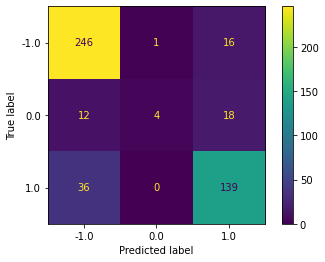

In [251]:
print("Accuracy score of the model is: ", accuracy_score(y_test, y_pred))
plot_confusion_matrix(rfc, X_test, y_test);

## Conclusion

Best Algorithm was the Random Forest Classifier 

## Super Learner Optimization 

In [262]:
model = SuperLearner(
    folds=5, 
    random_state=666
)

model.add(
    [
        bc, 
        lgb, 
        xgb, 
        rf,  
    ]
)

model.add_meta(
    LogisticRegression()
)

model.fit(X, y)

preds = model.predict(X_val)

print('SuperLearner accuracy: ', accuracy_score(y_val, preds))

/Users/andrewilliams/Documents/Dev/DS-2.9-Technical-Seminar/my_env/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/andrewilliams/Documents/Dev/DS-2.9-Technical-Seminar/my_env/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, U

SuperLearner accuracy:  0.8516949152542372


In [264]:
mdict = {
    'RF': RandomForestClassifier(random_state=666),
    'XGB': XGBClassifier(random_state=666),
    'LGBM': LGBMClassifier(random_state=666),
    'DT': DecisionTreeClassifier(random_state=666),
    'KNN': KNeighborsClassifier(),
    'BC': BaggingClassifier(random_state=666),
    'OARF': RandomForestClassifier(**rf_acc_params),
    'OAXGB': XGBClassifier(**xgb_acc_params),
    'OALGBM': LGBMClassifier(**lgb_acc_params),
    'OADT': DecisionTreeClassifier(**dt_acc_params),
    'OAKNN': KNeighborsClassifier(**knn_acc_params),
    'OABC': BaggingClassifier(**bc_acc_params),
    'OAABC': AdaBoostClassifier(**abc_acc_params),
    'OAET': ExtraTreesClassifier(**et_acc_params),
    'LR': LogisticRegression(random_state=666),
    'ABC': AdaBoostClassifier(random_state=666),
    'SGD': SGDClassifier(random_state=666), 
    'ET': ExtraTreesClassifier(random_state=666),
    'MLP': MLPClassifier(random_state=666),
    'GB': GradientBoostingClassifier(random_state=666),
    'RDG': RidgeClassifier(random_state=666),
    'PCP': Perceptron(random_state=666),
    'PAC': PassiveAggressiveClassifier(random_state=666)
}

NameError: name 'dt_acc_params' is not defined

In [247]:
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# yt = le.fit_transform(y_train)
# yt

In [248]:
# def create_model(trial):
#     model_names = list()
#     models_list = [
#         'RF', 'XGB', 'LGBM', 'DT', 
#         'KNN', 'BC', 'OARF', #'OFRF', 
#         'OAXGB', 'OFXGB', 'OALGBM', 
#         'OFLGBM', 'OADT', 'OFDT', 
#         'OAKNN', 
#         'OFBC', 'OAABC', 'OFABC', 
#         'OAET', 'OFET', 'LR', 
#         'ABC', 'SGD', 'ET', 
#         'MLP', 'GB', 'RDG', 
#         'PCP', 'PAC'
#     ]
    
#     head_list = [
#         'RF', 
#         'XGB', 
#         'LGBM', 
#         'DT', 
#         'KNN', 
# #       'BC', 
#         'LR', 
#         'ABC', 
#         'SGD', 
#         'ET', 
#         'MLP', 
#         'GB', 
#         'RDG', 
#         'PCP', 
#         'PAC'
#     ]
    
#     n_models = trial.suggest_int("n_models", 2, 6)
#     for i in range(n_models):
#         model_item = trial.suggest_categorical('model_{}'.format(i), models_list)
#         if model_item not in model_names:
#             model_names.append(model_item)
    
#     folds = trial.suggest_int("folds", 2, 6)
    
#     model = SuperLearner(
#         folds=folds, 
#         random_state=666
#     )
    
#     models = [
#         mdict[item] for item in model_names
#     ]
#     model.add(models)
#     head = trial.suggest_categorical('head', head_list)
#     model.add_meta(
#         mdict[head]
#     )
        
#     return model

# def objective(trial):
#     model = create_model(trial)
#     model.fit(X, y_train)
#     preds = model.predict(X_val)
#     score = accuracy_score(y_val, preds)
#     return score

# study = optuna.create_study(
#     direction="maximize", 
#     sampler=sampler
# )

# study.optimize(
#     objective, 
#     n_trials=50
# )

In [249]:
# params = study.best_params

# head = params['head']
# folds = params['folds']
# del params['head'], params['n_models'], params['folds']
# result = list()
# for key, value in params.items():
#     if value not in result:
#         result.append(value)
        
# result

In [250]:
# model = SuperLearner(
#     folds=folds, 
#     random_state=666
# )

# models = [
#     mdict[item] for item in result
# ]
# model.add(models)
# model.add_meta(mdict[head])

# model.fit(X, y)

# preds = model.predict(X_val)

# print('Optimized SuperLearner accuracy: ', accuracy_score(y_val, preds))
# print('Optimized SuperLearner f1-score: ', f1_score(y_val, preds))